c:\Users\hp\anaconda3\envs\py310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


📊 Fetched 4140 posts from the last 60 days
🔍 Performing sentiment analysis...
📈 Analyzing posting trends...
🔑 Extracting common topics...

📊 OVERALL STATISTICS:
Total Posts Analyzed: 4140
Average Upvotes: 18.00
Average Post Length: 957.61 characters
Average Sentiment Polarity: -0.0012
Sentiment Distribution: {'positive': 1466, 'negative': 1368, 'neutral': 1306}

✅ Analysis complete! Visualizations saved.


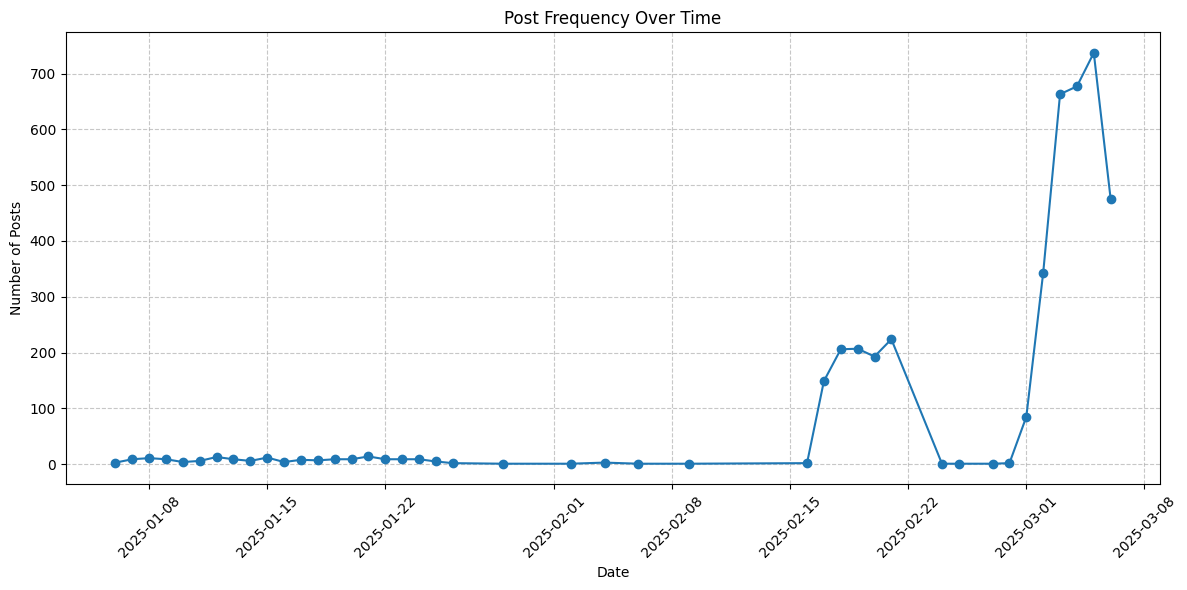

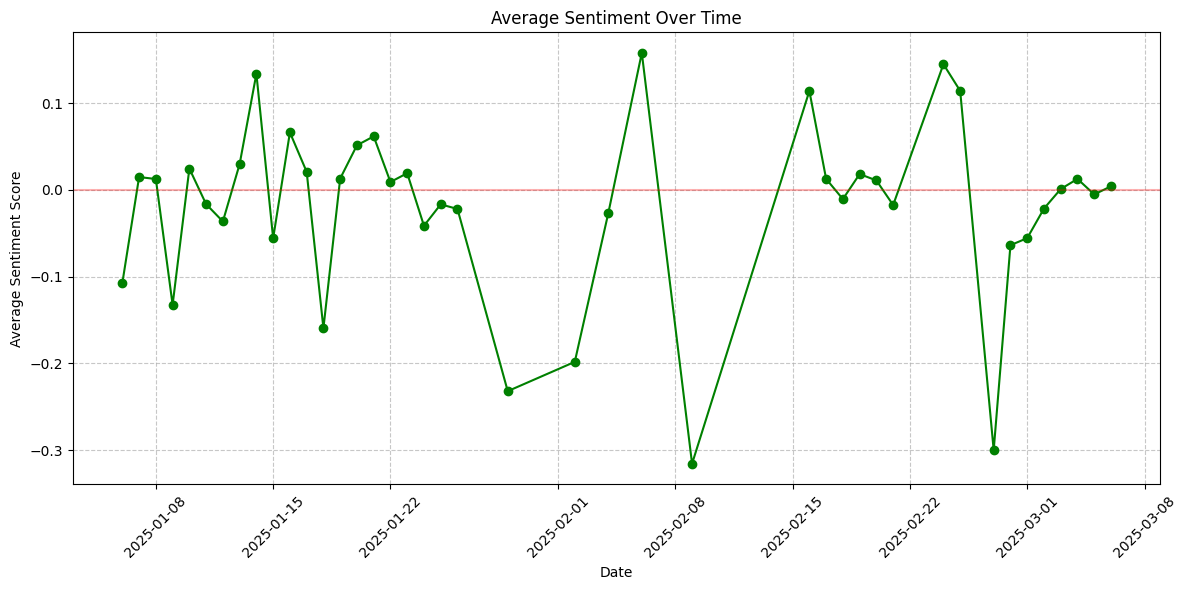

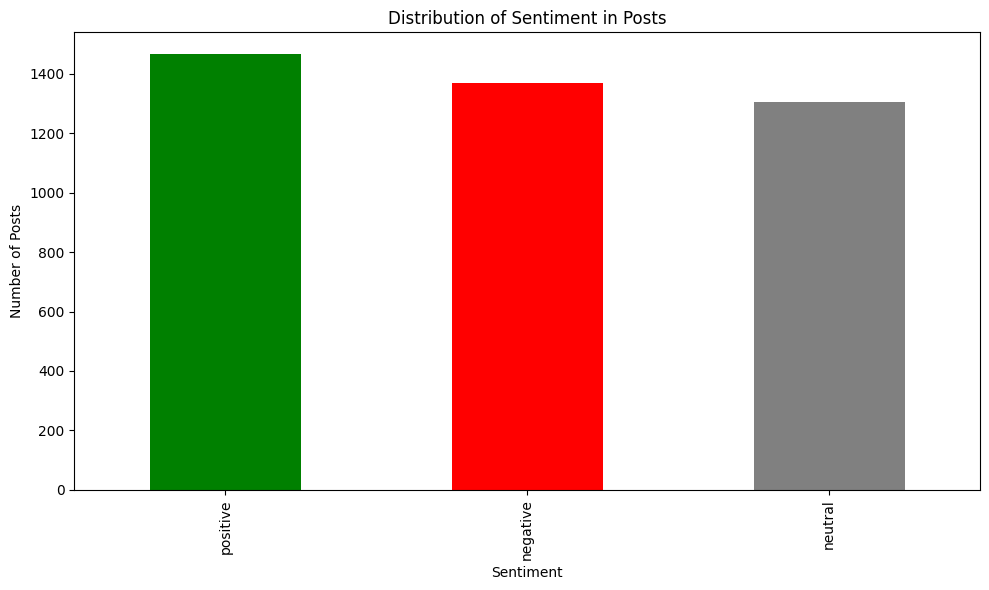

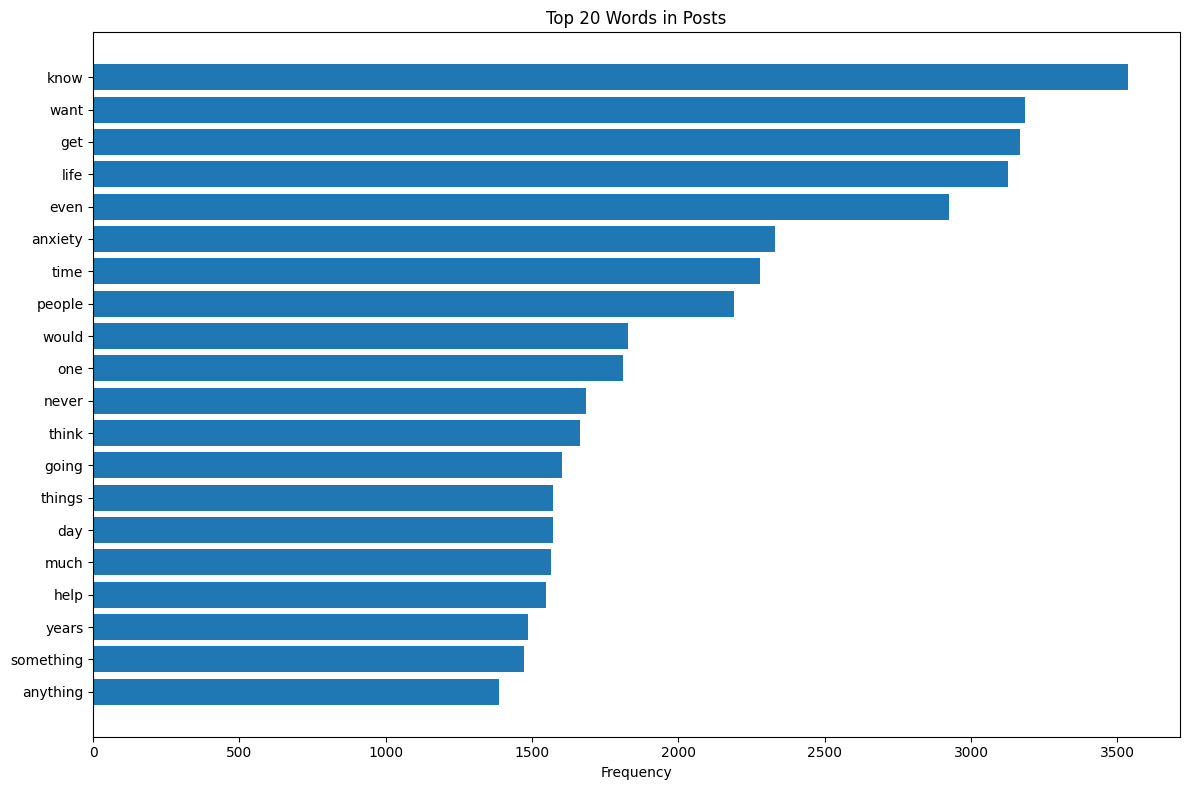

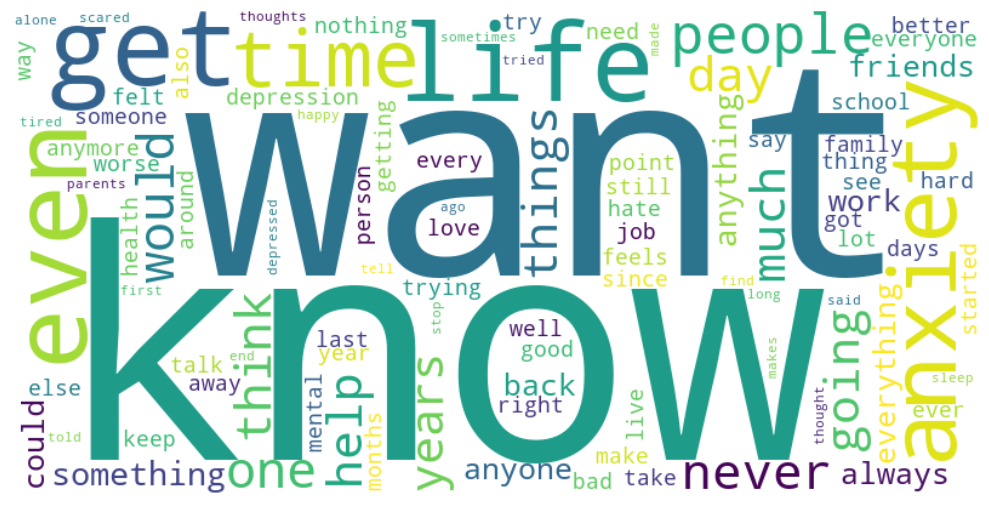

In [ ]:
import pandas as pd
import numpy as np
import pymysql
from db_config import MYSQL_HOST, MYSQL_USER, MYSQL_PASSWORD, MYSQL_DATABASE
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from transformers import pipeline

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Database connection function (reusing from your existing code)
def connect_db():
    """Establishes a connection to the MySQL database."""
    try:
        conn = pymysql.connect(
            host=MYSQL_HOST,
            user=MYSQL_USER,
            password=MYSQL_PASSWORD,
            database=MYSQL_DATABASE,
            charset='utf8mb4',
            cursorclass=pymysql.cursors.DictCursor
        )
        return conn
    except pymysql.MySQLError as e:
        print("❌ Database Connection Error:", e)
        return None

# Function 1: Fetch posts from database
def fetch_posts(days_ago=30):
    """Fetches posts from the database within the specified time period."""
    conn = connect_db()
    if not conn:
        return []
    
    try:
        cursor = conn.cursor()
        query = """
        SELECT * FROM reddit_posts 
        WHERE created_at >= DATE_SUB(NOW(), INTERVAL %s DAY)
        ORDER BY created_at DESC
        """
        cursor.execute(query, (days_ago,))
        posts = cursor.fetchall()
        print(f"📊 Fetched {len(posts)} posts from the last {days_ago} days")
        return posts
    except pymysql.MySQLError as e:
        print("❌ MySQL Error:", e)
        return []
    finally:
        cursor.close()
        conn.close()

# Function 2: Basic Sentiment Analysis with TextBlob
def analyze_sentiment_textblob(text):
    """Analyzes sentiment of a text using TextBlob."""
    analysis = TextBlob(text)
    
    # Determine sentiment category
    if analysis.sentiment.polarity > 0.05:
        sentiment = "positive"
    elif analysis.sentiment.polarity < -0.05:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    
    return {
        "polarity": analysis.sentiment.polarity,
        "subjectivity": analysis.sentiment.subjectivity,
        "sentiment": sentiment
    }

# Function 3: Advanced Sentiment Analysis with Hugging Face
def analyze_sentiment_advanced(texts, batch_size=16):
    """Analyzes sentiment using a pre-trained transformer model."""
    sentiment_analyzer = pipeline("sentiment-analysis", model = "distilbert-base-uncased-finetuned-sst-2-english")
    
    # Process in batches to avoid memory issues
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_results = sentiment_analyzer(batch)
        results.extend(batch_results)
    
    return results

# Function 4: Time Series Analysis
def analyze_post_trends(posts):
    """Analyzes posting trends over time."""
    df = pd.DataFrame(posts)
    
    # Convert created_at to datetime
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    # Create date column for grouping
    df['date'] = df['created_at'].dt.date
    
    # Group by date and count posts
    daily_counts = df.groupby('date').size().reset_index(name='post_count')
    
    # Calculate daily average sentiment
    df['sentiment_score'] = df['body'].apply(lambda x: analyze_sentiment_textblob(x)['polarity'])
    daily_sentiment = df.groupby('date')['sentiment_score'].mean().reset_index(name='avg_sentiment')
    
    # Merge the two dataframes
    trend_data = pd.merge(daily_counts, daily_sentiment, on='date')
    
    return trend_data

# Function 5: Common Topics/Keywords Analysis
def analyze_common_topics(posts, top_n=20):
    """Extracts and counts common topics/keywords from posts."""
    stop_words = set(stopwords.words('english'))
    additional_stops = {"like", "just", "feel", "feeling", "really", "i'm", "im", "don't", "dont"}
    stop_words.update(additional_stops)
    
    all_words = []
    
    for post in posts:
        # Combine title and body for full text analysis
        text = f"{post['title']} {post['body']}"
        
        # Tokenize and filter
        words = word_tokenize(text.lower())
        filtered_words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 2]
        
        all_words.extend(filtered_words)
    
    # Count occurrences
    word_counts = Counter(all_words)
    
    # Get top N words
    top_words = word_counts.most_common(top_n)
    
    return top_words, word_counts

# Function 6: Generate Word Cloud
def generate_wordcloud(word_counts):
    """Generates a word cloud from word counts."""
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=100,
        colormap='viridis',
        contour_width=1
    ).generate_from_frequencies(dict(word_counts))
    
    return wordcloud

# Function 7: Overall Statistics
def get_statistics(posts):
    """Calculates overall statistics from the posts."""
    df = pd.DataFrame(posts)
    
    # Basic statistics
    total_posts = len(posts)
    avg_upvotes = df['upvotes'].mean()
    
    # Apply sentiment analysis to all posts
    sentiments = [analyze_sentiment_textblob(post['body']) for post in posts]
    sentiment_df = pd.DataFrame(sentiments)
    
    # Calculate sentiment distribution
    sentiment_counts = sentiment_df['sentiment'].value_counts()
    avg_polarity = sentiment_df['polarity'].mean()
    avg_subjectivity = sentiment_df['subjectivity'].mean()
    
    # Post length analysis
    df['body_length'] = df['body'].apply(len)
    avg_length = df['body_length'].mean()
    
    return {
        'total_posts': total_posts,
        'avg_upvotes': avg_upvotes,
        'sentiment_distribution': sentiment_counts.to_dict(),
        'avg_polarity': avg_polarity,
        'avg_subjectivity': avg_subjectivity,
        'avg_post_length': avg_length
    }

# Main analysis workflow
def main():
    # 1. Fetch posts from database (last 30 days)
    posts = fetch_posts(days_ago=60)
    
    if not posts:
        print("❌ No posts found for analysis")
        return
    
    # 2. Perform sentiment analysis
    print("🔍 Performing sentiment analysis...")
    df = pd.DataFrame(posts)
    df['sentiment'] = df['body'].apply(lambda x: analyze_sentiment_textblob(x)['sentiment'])
    df['polarity'] = df['body'].apply(lambda x: analyze_sentiment_textblob(x)['polarity'])
    
    # 3. Analyze trends over time
    print("📈 Analyzing posting trends...")
    trend_data = analyze_post_trends(posts)
    
    # 4. Extract common topics
    print("🔑 Extracting common topics...")
    top_words, word_counts = analyze_common_topics(posts)
    
    # 5. Generate visualization: Post frequency over time
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data['date'], trend_data['post_count'], marker='o')
    plt.title('Post Frequency Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('post_frequency.png')
    
    # 6. Generate visualization: Sentiment trends over time
    plt.figure(figsize=(12, 6))
    plt.plot(trend_data['date'], trend_data['avg_sentiment'], marker='o', color='green')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.title('Average Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment Score')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('sentiment_trends.png')
    
    # 7. Generate visualization: Sentiment distribution
    plt.figure(figsize=(10, 6))
    sentiment_counts = df['sentiment'].value_counts()
    colors = {'positive': 'green', 'neutral': 'gray', 'negative': 'red'}
    sentiment_counts.plot(kind='bar', color=[colors[x] for x in sentiment_counts.index])
    plt.title('Distribution of Sentiment in Posts')
    plt.xlabel('Sentiment')
    plt.ylabel('Number of Posts')
    plt.tight_layout()
    plt.savefig('sentiment_distribution.png')
    
    # 8. Generate visualization: Word frequency
    plt.figure(figsize=(12, 8))
    words, counts = zip(*top_words)
    plt.barh(list(reversed(words)), list(reversed(counts)))
    plt.title('Top 20 Words in Posts')
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.savefig('word_frequency.png')
    
    # 9. Generate word cloud
    wordcloud = generate_wordcloud(word_counts)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('wordcloud.png')
    
    # 10. Calculate and display overall statistics
    stats = get_statistics(posts)
    print("\n📊 OVERALL STATISTICS:")
    print(f"Total Posts Analyzed: {stats['total_posts']}")
    print(f"Average Upvotes: {stats['avg_upvotes']:.2f}")
    print(f"Average Post Length: {stats['avg_post_length']:.2f} characters")
    print(f"Average Sentiment Polarity: {stats['avg_polarity']:.4f}")
    print(f"Sentiment Distribution: {stats['sentiment_distribution']}")
    
    print("\n✅ Analysis complete! Visualizations saved.")

if __name__ == "__main__":
    main()

2025-03-13 15:07:29.596 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-13 15:07:29.599 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-13 15:07:29.601 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-13 15:07:29.604 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-13 15:07:29.607 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-13 15:07:29.610 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-03-13 15:07:29.611 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-13 15:07:30.602 
  command:

    streamlit run C:\Users\h

🔬 Starting advanced content analysis...
📊 Performing topic modeling with LDA...
🧐 Analyzing sentiment by topic...
🔍 Performing clustering analysis...
🎨 Generating advanced visualizations...

🔎 ADVANCED ANALYSIS RESULTS:

Top words per topic:
       Topic 0 Topic 1  Topic 2  Topic 3     Topic 4
0         help    feel  anxiety     feel  depression
1         work    like     feel     like        self
2      anxiety    want     like     know        hair
3       mental    life      day    think      people
4   depression    know    start    thing        year
5         year  friend   attack     time         try
6         need    year    panic     want        live
7       health  people      bad   people       world
8          try    time    sleep  feeling         car
9         know   think     week      bad         new
10        time     day     time   happen         end
11     therapy     try  symptom  thought     suicide
12        want    live      eat      way        easy
13    struggle  

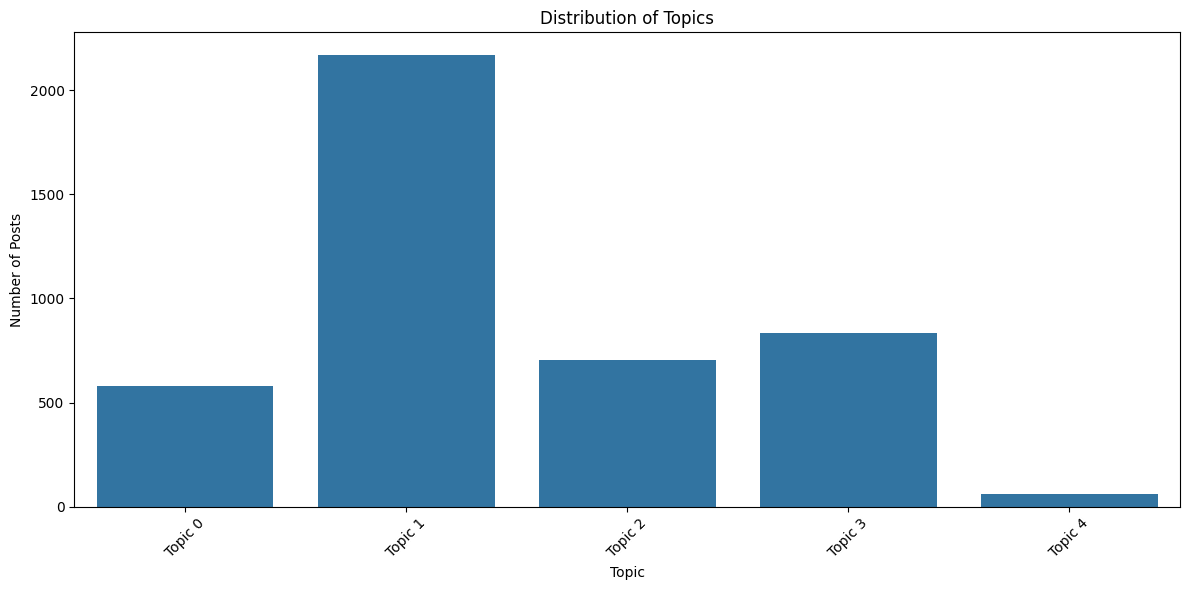

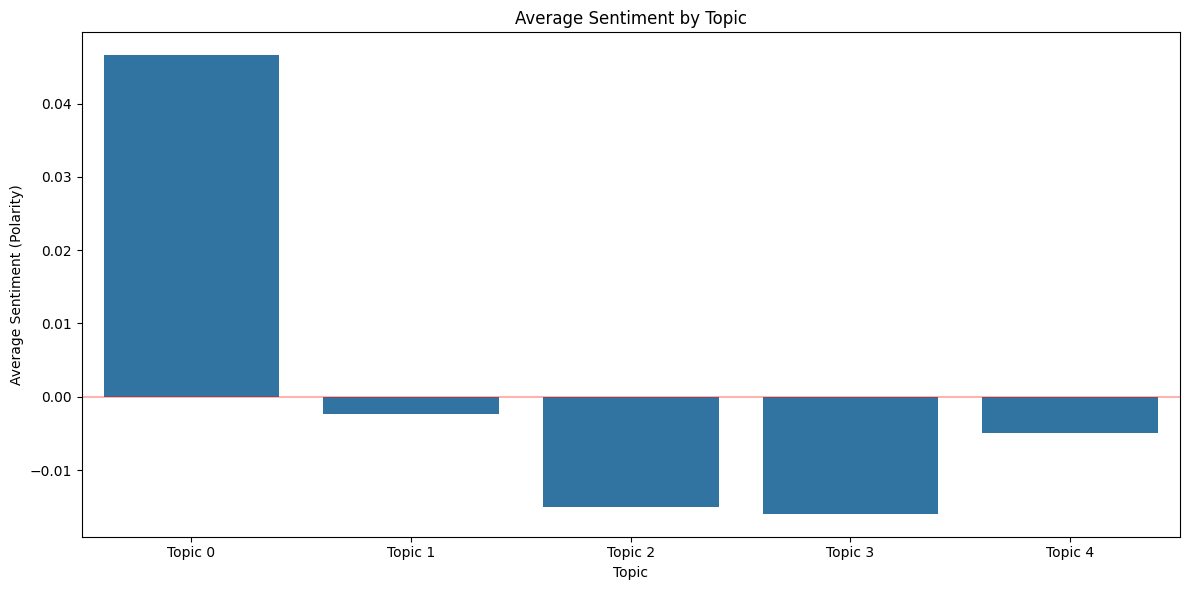

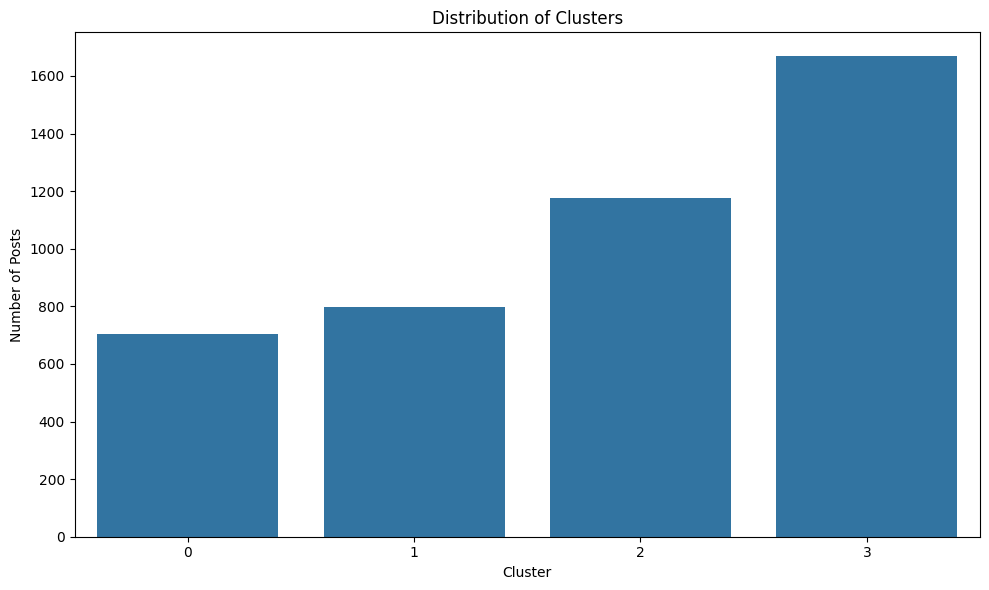

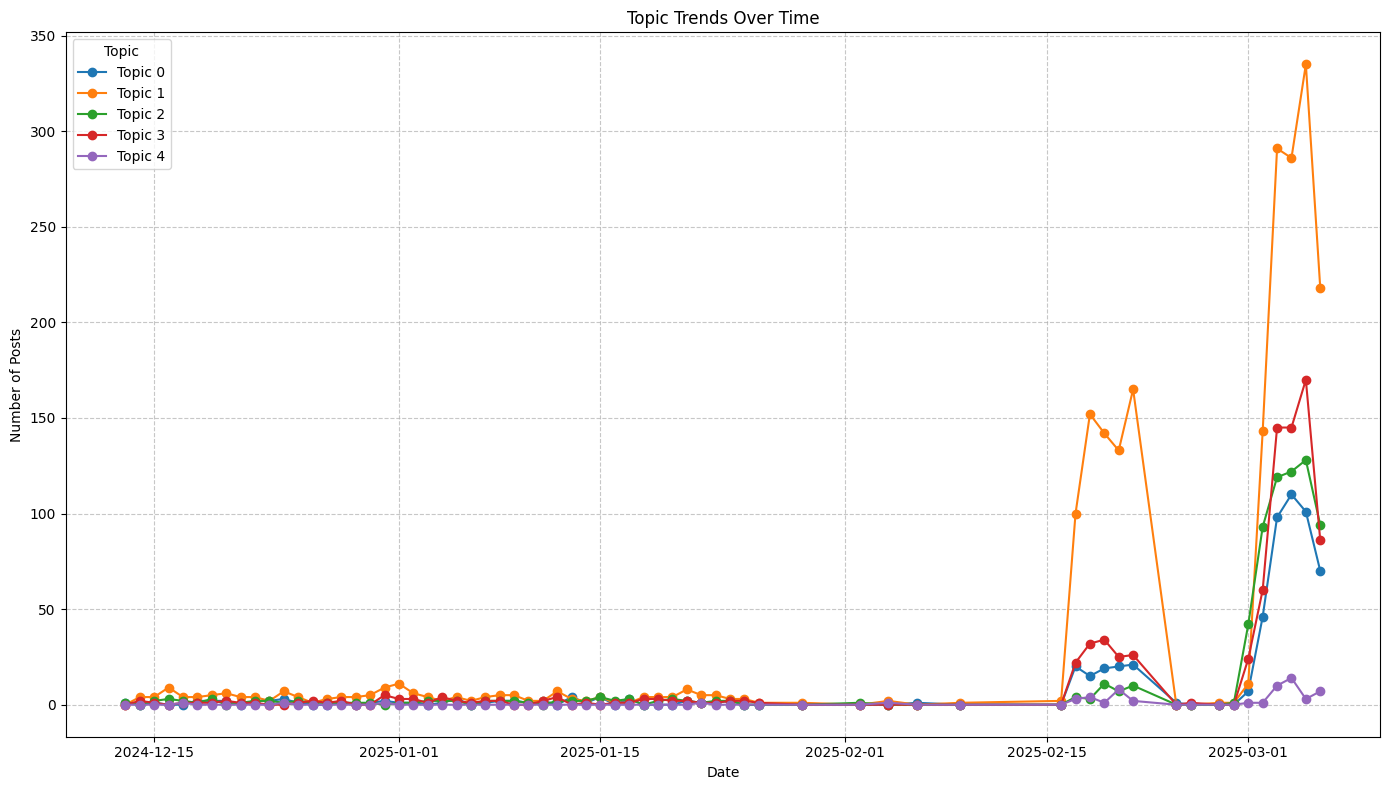

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.cluster import KMeans
from gensim.models import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import spacy
import pyLDAvis
import pyLDAvis.gensim_models

# Load the data (assuming we have posts from the previous script)
def perform_advanced_analysis(posts_df):
    """
    Performs advanced topic modeling and clustering on Reddit posts
    
    Args:
        posts_df: Pandas DataFrame with 'title', 'body', and other post data
    """
    # Combine title and body for analysis
    posts_df['full_text'] = posts_df['title'] + ' ' + posts_df['body']
    
    print("🔬 Starting advanced content analysis...")
    
    # 1. Topic Modeling with LDA
    print("📊 Performing topic modeling with LDA...")
    
    # Process text data
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    def preprocess_text(text):
        """Process text for topic modeling"""
        # Remove punctuation, numbers, and lowercase
        doc = nlp(text)
        result = []
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.like_num:
                result.append(token.lemma_.lower())
        return " ".join(result)
    
    # Preprocess the texts
    posts_df['processed_text'] = posts_df['full_text'].apply(preprocess_text)
    
    # Create Document-Term Matrix
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(posts_df['processed_text'])
    
    # Create LDA model
    lda_model = LatentDirichletAllocation(
        n_components=5,  # Number of topics
        random_state=42,
        max_iter=50
    )
    
    lda_output = lda_model.fit_transform(dtm)
    
    # Get the dominant topic for each document
    topic_names = ["Topic " + str(i) for i in range(lda_model.n_components)]
    doc_names = [f"Doc {i}" for i in range(len(posts_df))]
    
    df_document_topics = pd.DataFrame(lda_output, columns=topic_names, index=doc_names)
    dominant_topic = df_document_topics.idxmax(axis=1)
    posts_df['dominant_topic'] = dominant_topic.values
    
    # Get the top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a DataFrame to store top words per topic
    topics_df = pd.DataFrame()
    
    # Get top 15 words for each topic
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-16:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics_df[f"Topic {topic_idx}"] = top_words
    
    # 2. Sentiment Analysis by Topic
    print("🧐 Analyzing sentiment by topic...")
    
    # Group posts by dominant topic and calculate average sentiment
    topic_sentiment = posts_df.groupby('dominant_topic')['polarity'].mean().reset_index()
    
    # 3. Clustering Analysis
    print("🔍 Performing clustering analysis...")
    
    # Use TF-IDF for clustering
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(posts_df['processed_text'])
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    posts_df['cluster'] = kmeans.fit_predict(tfidf)
    
    # Get cluster centers and top terms per cluster
    centroids = kmeans.cluster_centers_
    
    # Get top 10 terms for each cluster
    cluster_terms = {}
    for i in range(kmeans.n_clusters):
        indices = centroids[i].argsort()[-10:]
        cluster_terms[f"Cluster {i}"] = [tfidf_vectorizer.get_feature_names_out()[ind] for ind in indices]
    
    # 4. Generate Visualizations
    print("🎨 Generating advanced visualizations...")
    
    # Topic Distribution
    plt.figure(figsize=(12, 6))
    topic_counts = posts_df['dominant_topic'].value_counts().sort_index()
    sns.barplot(x=topic_counts.index, y=topic_counts.values)
    plt.title('Distribution of Topics')
    plt.xlabel('Topic')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('topic_distribution.png')
    
    # Topic Sentiment Analysis
    plt.figure(figsize=(12, 6))
    sns.barplot(x='dominant_topic', y='polarity', data=topic_sentiment)
    plt.title('Average Sentiment by Topic')
    plt.xlabel('Topic')
    plt.ylabel('Average Sentiment (Polarity)')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.savefig('topic_sentiment.png')
    
    # Cluster Distribution
    plt.figure(figsize=(10, 6))
    cluster_counts = posts_df['cluster'].value_counts().sort_index()
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
    plt.title('Distribution of Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Posts')
    plt.tight_layout()
    plt.savefig('cluster_distribution.png')
    
    # Interactive LDA Visualization (if needed - requires web browser)
    # corpus = [doc.split() for doc in posts_df['processed_text']]
    # id2word = corpora.Dictionary(corpus)
    # corpus_gensim = [id2word.doc2bow(doc) for doc in corpus]
    # lda_model_gensim = gensim.models.LdaModel(corpus=corpus_gensim, id2word=id2word, num_topics=5)
    # vis = pyLDAvis.gensim_models.prepare(lda_model_gensim, corpus_gensim, id2word)
    # pyLDAvis.save_html(vis, 'lda_visualization.html')
    
    # Return analysis results
    return {
        'topics_df': topics_df,
        'topic_sentiment': topic_sentiment,
        'cluster_terms': cluster_terms,
        'posts_with_topics': posts_df
    }

# Example function to visualize temporal trends by topic
def analyze_topic_trends(posts_df_with_topics):
    """
    Analyzes and visualizes how topics change over time
    
    Args:
        posts_df_with_topics: DataFrame with posts and their assigned topics
    """
    # Convert created_at to datetime if needed
    if not pd.api.types.is_datetime64_any_dtype(posts_df_with_topics['created_at']):
        posts_df_with_topics['created_at'] = pd.to_datetime(posts_df_with_topics['created_at'])
    
    # Create a date column
    posts_df_with_topics['date'] = posts_df_with_topics['created_at'].dt.date
    
    # Group by date and topic, count posts
    topic_date_counts = posts_df_with_topics.groupby(['date', 'dominant_topic']).size().reset_index(name='count')
    
    # Pivot the data for easier plotting
    topic_trends = topic_date_counts.pivot(index='date', columns='dominant_topic', values='count').fillna(0)
    
    # Plot the trends
    plt.figure(figsize=(14, 8))
    topic_trends.plot(kind='line', marker='o', ax=plt.gca())
    plt.title('Topic Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Posts')
    plt.legend(title='Topic')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('topic_trends.png')
    
    return topic_trends

# Example of using all the functions
def run_advanced_analysis():
    """Main function to run the advanced analysis pipeline"""
    from reddit_analysis import fetch_posts, analyze_sentiment_textblob
    
    # 1. Fetch posts
    posts = fetch_posts(days_ago=90)  # Get 3 months of data for better trend analysis
    
    if not posts:
        print("❌ No posts found for analysis")
        return
    
    # 2. Convert to DataFrame
    df = pd.DataFrame(posts)
    
    # 3. Add sentiment analysis
    df['sentiment_data'] = df['body'].apply(analyze_sentiment_textblob)
    df['polarity'] = df['sentiment_data'].apply(lambda x: x['polarity'])
    df['sentiment'] = df['sentiment_data'].apply(lambda x: x['sentiment'])
    
    # 4. Run advanced analysis
    analysis_results = perform_advanced_analysis(df)
    
    # 5. Analyze topic trends over time
    topic_trends = analyze_topic_trends(analysis_results['posts_with_topics'])
    
    # 6. Print summary of findings
    print("\n🔎 ADVANCED ANALYSIS RESULTS:")
    print("\nTop words per topic:")
    print(analysis_results['topics_df'])
    
    print("\nSentiment by topic:")
    print(analysis_results['topic_sentiment'])
    
    print("\nTop terms per cluster:")
    for cluster, terms in analysis_results['cluster_terms'].items():
        print(f"{cluster}: {', '.join(terms)}")
    
    print("\n✅ Advanced analysis complete! Visualizations saved.")

if __name__ == "__main__":
    run_advanced_analysis()